In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [10]:
# Random number SEED generators 
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cpu
Device: cpu
CUDA available: False


In [11]:
## Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


#### CNN Model

In [12]:
class HairClassifier(nn.Module):
    def __init__(self):
        super(HairClassifier, self).__init__()
        
        # Convolutional layer: 32 filters, 3x3 kernel
        # Input: (3, 200, 200) → Output: (32, 198, 198)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3))
        
        # Max pooling: 2x2
        # Input: (32, 198, 198) → Output: (32, 99, 99)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))
        
        # Fully connected layer 1: 313632 → 64
        # 32 * 99 * 99 = 313,632
        self.fc1 = nn.Linear(32 * 99 * 99, 64)
        
        # Output layer: 64 → 1 (binary classification)
        self.fc2 = nn.Linear(64, 1)
    
    def forward(self, x):
        # Conv + ReLU activation
        x = torch.relu(self.conv1(x))
        
        # Max pooling
        x = self.pool(x)
        
        # Flatten using view
        x = x.view(x.size(0), -1)
        
        # FC1 + ReLU activation
        x = torch.relu(self.fc1(x))
        
        # Output layer (NO activation - BCEWithLogitsLoss includes sigmoid)
        x = self.fc2(x)
        
        return x

# Model instance
model = HairClassifier().to(device)
model

HairClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=313632, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
)

#### QUESTION 1: Loss Function - nn.BCEWithLogitsLoss()

In [13]:
criterion = nn.BCEWithLogitsLoss()

#### Question 2: Number of parameters

In [14]:
from torchsummary import summary

summary(model, input_size=(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
         MaxPool2d-2           [-1, 32, 99, 99]               0
            Linear-3                   [-1, 64]      20,072,512
            Linear-4                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 11.96
Params size (MB): 76.57
Estimated Total Size (MB): 89.00
----------------------------------------------------------------


In [15]:
# Setup optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.002, momentum=0.8)

#### Prepare Data Loaders (WITHOUT Augmentation)

In [16]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) 
])

test_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) 
])

# Load datasets
train_dataset = datasets.ImageFolder('data/train', transform=train_transforms)
validation_dataset = datasets.ImageFolder('data/test', transform=test_transforms)

# Create data loaders (batch_size=20)
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=20, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(validation_dataset)}")
print(f"Classes: {train_dataset.classes}")
print(f"Class to index: {train_dataset.class_to_idx}") 

Training samples: 801
Validation samples: 201
Classes: ['curly', 'straight']
Class to index: {'curly': 0, 'straight': 1}


In [17]:
# Training loop
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

print("TRAINING: First 10 epochs WITHOUT data augmentation")

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)  # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

print("Training completed!")

TRAINING: First 10 epochs WITHOUT data augmentation
Epoch 1/10, Loss: 0.6410, Acc: 0.6429, Val Loss: 0.6208, Val Acc: 0.5970
Epoch 2/10, Loss: 0.5481, Acc: 0.6966, Val Loss: 0.6113, Val Acc: 0.6269
Epoch 3/10, Loss: 0.5131, Acc: 0.7391, Val Loss: 0.6217, Val Acc: 0.6617
Epoch 4/10, Loss: 0.4483, Acc: 0.7778, Val Loss: 0.8186, Val Acc: 0.5871
Epoch 5/10, Loss: 0.4237, Acc: 0.8102, Val Loss: 0.6149, Val Acc: 0.6915
Epoch 6/10, Loss: 0.3484, Acc: 0.8452, Val Loss: 0.8339, Val Acc: 0.6070
Epoch 7/10, Loss: 0.3163, Acc: 0.8602, Val Loss: 0.7869, Val Acc: 0.6567
Epoch 8/10, Loss: 0.2192, Acc: 0.9139, Val Loss: 0.8456, Val Acc: 0.6965
Epoch 9/10, Loss: 0.1657, Acc: 0.9438, Val Loss: 0.7794, Val Acc: 0.7164
Epoch 10/10, Loss: 0.1181, Acc: 0.9513, Val Loss: 1.8357, Val Acc: 0.6119
Training completed!


#### Question 3 (Median) + 4 (Standard Deviation)

In [18]:
# QUESTION 3: Median of training accuracy
median_train_acc = np.median(history['acc'])
print(f"Median training accuracy: {median_train_acc:.4f}")
print()

# QUESTION 4: Standard deviation of training loss
std_train_loss = np.std(history['loss'])
print(f"Training loss: {std_train_loss:.4f}")
print()

# Print all training metrics for reference
print("All training accuracies:", [f"{acc:.4f}" for acc in history['acc']])
print("All training losses:", [f"{loss:.4f}" for loss in history['loss']])

Median training accuracy: 0.8277

Training loss: 0.1630

All training accuracies: ['0.6429', '0.6966', '0.7391', '0.7778', '0.8102', '0.8452', '0.8602', '0.9139', '0.9438', '0.9513']
All training losses: ['0.6410', '0.5481', '0.5131', '0.4483', '0.4237', '0.3484', '0.3163', '0.2192', '0.1657', '0.1181']


#### Plot Training Progress

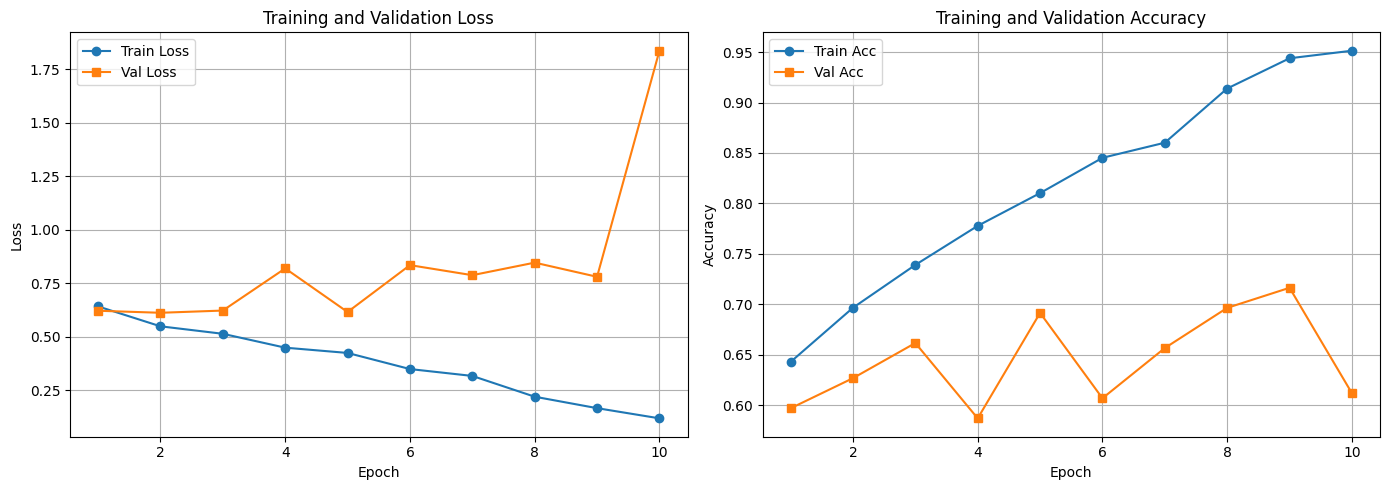

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
axes[0].plot(range(1, 11), history['loss'], marker='o', label='Train Loss')
axes[0].plot(range(1, 11), history['val_loss'], marker='s', label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(range(1, 11), history['acc'], marker='o', label='Train Acc')
axes[1].plot(range(1, 11), history['val_acc'], marker='s', label='Val Acc')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

#### QUESTIONS 5 & 6: Training WITH Data Augmentation

In [20]:
train_transforms_aug = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Recreate training dataset WITH augmentation
train_dataset_aug = datasets.ImageFolder('data/train', transform=train_transforms_aug)
print(train_dataset_aug)
print()
train_loader_aug = DataLoader(train_dataset_aug, batch_size=20, shuffle=True)
print(train_loader_aug)

Dataset ImageFolder
    Number of datapoints: 801
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=True)
               RandomRotation(degrees=[-50.0, 50.0], interpolation=nearest, expand=False, fill=0)
               RandomResizedCrop(size=(200, 200), scale=(0.9, 1.0), ratio=(0.9, 1.1), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )



#### Continue Training with Augmentation

In [21]:
num_epochs_aug = 10
history_aug = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

print("TRAINING: 10 epochs WITH data augmentation")

for epoch in range(num_epochs_aug):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader_aug:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_dataset_aug)
    epoch_acc = correct_train / total_train
    history_aug['loss'].append(epoch_loss)
    history_aug['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(validation_dataset)
    val_epoch_acc = correct_val / total_val
    history_aug['val_loss'].append(val_epoch_loss)
    history_aug['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs_aug} (Augmented), "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")

print("Training completed!")

TRAINING: 10 epochs WITH data augmentation
Epoch 1/10 (Augmented), Loss: 0.8343, Acc: 0.5531, Val Loss: 0.6060, Val Acc: 0.6965
Epoch 2/10 (Augmented), Loss: 0.6165, Acc: 0.6255, Val Loss: 0.6902, Val Acc: 0.6517
Epoch 3/10 (Augmented), Loss: 0.6154, Acc: 0.6754, Val Loss: 0.6280, Val Acc: 0.7065
Epoch 4/10 (Augmented), Loss: 0.6116, Acc: 0.6916, Val Loss: 0.6500, Val Acc: 0.6816
Epoch 5/10 (Augmented), Loss: 0.5848, Acc: 0.6879, Val Loss: 0.5712, Val Acc: 0.7065
Epoch 6/10 (Augmented), Loss: 0.5502, Acc: 0.7091, Val Loss: 0.5790, Val Acc: 0.6965
Epoch 7/10 (Augmented), Loss: 0.5742, Acc: 0.6866, Val Loss: 0.6262, Val Acc: 0.6368
Epoch 8/10 (Augmented), Loss: 0.5794, Acc: 0.7079, Val Loss: 0.7478, Val Acc: 0.6119
Epoch 9/10 (Augmented), Loss: 0.5880, Acc: 0.6854, Val Loss: 0.7389, Val Acc: 0.6020
Epoch 10/10 (Augmented), Loss: 0.5447, Acc: 0.7129, Val Loss: 0.7294, Val Acc: 0.6169
Training completed!


#### Question 5 - Mean Test

In [28]:
mean_val_loss_aug = np.mean(history_aug['val_loss'])
print(f"Mean Loss:{mean_val_loss_aug:.4f}")

Mean Loss:0.6567


#### Question 6 - Average Test

In [29]:
mean_val_acc_last5 = np.mean(history_aug['val_acc'][5:10])
print(f"Meav Accuracy:{mean_val_acc_last5:.4f}")

Meav Accuracy:0.6328


In [30]:
# Print all augmented metrics for reference
print("All validation losses (augmented):", [f"{loss:.4f}" for loss in history_aug['val_loss']])
print()
print("All validation accuracies (augmented):", [f"{acc:.4f}" for acc in history_aug['val_acc']])
print()
print("Last 5 validation accuracies:", [f"{acc:.4f}" for acc in history_aug['val_acc'][5:10]])

All validation losses (augmented): ['0.6060', '0.6902', '0.6280', '0.6500', '0.5712', '0.5790', '0.6262', '0.7478', '0.7389', '0.7294']

All validation accuracies (augmented): ['0.6965', '0.6517', '0.7065', '0.6816', '0.7065', '0.6965', '0.6368', '0.6119', '0.6020', '0.6169']

Last 5 validation accuracies: ['0.6965', '0.6368', '0.6119', '0.6020', '0.6169']


#### Plot Loss and Accuracy

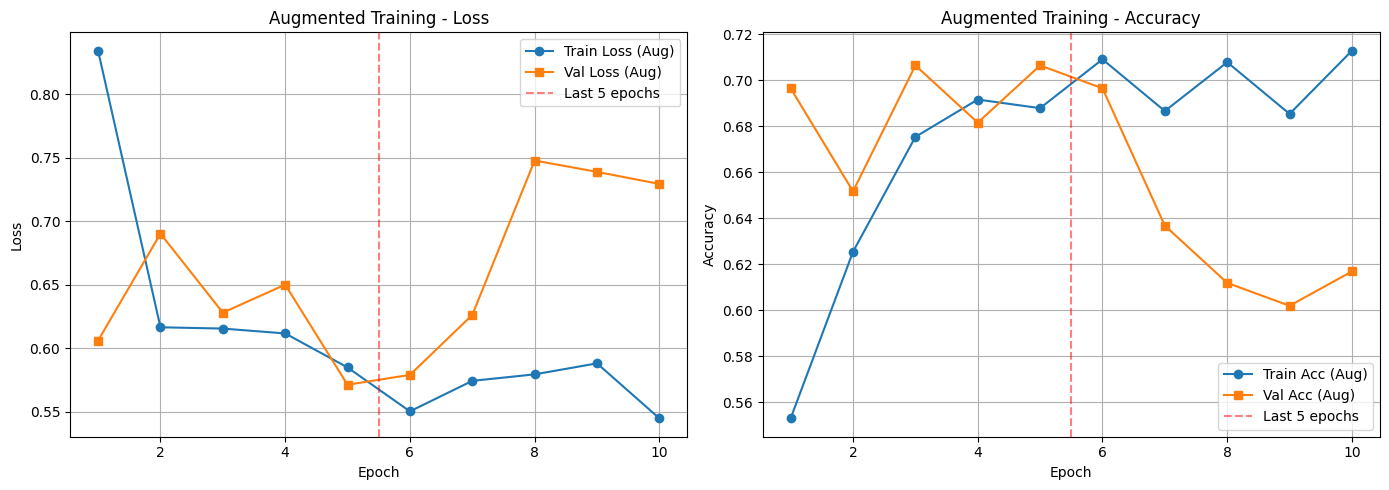

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
axes[0].plot(range(1, 11), history_aug['loss'], marker='o', label='Train Loss (Aug)')
axes[0].plot(range(1, 11), history_aug['val_loss'], marker='s', label='Val Loss (Aug)')
axes[0].axvline(x=5.5, color='red', linestyle='--', alpha=0.5, label='Last 5 epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Augmented Training - Loss')
axes[0].legend()
axes[0].grid(True)

# Plot Accuracy
axes[1].plot(range(1, 11), history_aug['acc'], marker='o', label='Train Acc (Aug)')
axes[1].plot(range(1, 11), history_aug['val_acc'], marker='s', label='Val Acc (Aug)')
axes[1].axvline(x=5.5, color='red', linestyle='--', alpha=0.5, label='Last 5 epochs')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Augmented Training - Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()